# Лабораторная работа №2. Named Entity Recognition (NER).

Данные: https://www.kaggle.com/datasets/naseralqaydeh/named-entity-recognition-ner-corpus

In [5]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from prettytable import PrettyTable

plt.style.use("seaborn-v0_8-darkgrid")

## EDA

In [6]:
df = pd.read_csv("data/ner.csv")
df.head()

,Sentence #,Sentence,POS,Tag
0,Sentence: 1,Thousands of demonstrators have marched throug...,"['NNS', 'IN', 'NNS', 'VBP', 'VBN', 'IN', 'NNP'...","['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', '..."
1,Sentence: 2,Families of soldiers killed in the conflict jo...,"['NNS', 'IN', 'NNS', 'VBN', 'IN', 'DT', 'NN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
2,Sentence: 3,They marched from the Houses of Parliament to ...,"['PRP', 'VBD', 'IN', 'DT', 'NNS', 'IN', 'NN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
3,Sentence: 4,"Police put the number of marchers at 10,000 wh...","['NNS', 'VBD', 'DT', 'NN', 'IN', 'NNS', 'IN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
4,Sentence: 5,The protest comes on the eve of the annual con...,"['DT', 'NN', 'VBZ', 'IN', 'DT', 'NN', 'IN', 'D...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."


In [7]:
df.shape

(47959, 4)

Датасет содержит 47959 предложений

In [8]:
sentences = df['Sentence'].tolist()
tags_list = df['Tag'].tolist()
sentences[45], tags_list[45]

('Pakistani officials say unidentified gunmen have killed three people , including a former government minister , in a semi-autonomous tribal region bordering Afghanistan .',
 "['B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O']")

In [9]:
type(tags_list[0])

str

Список тэгов на самом деле является строкой, исправим.

In [10]:
sentences[134]

'Israeli Prime Minister Ehud Olmert and Palestinian President Mahmoud Abbas resumed U.S.-brokered peace talks last November , but progress has been slow .'

In [11]:
tags_list = [fake_list.replace("'", "").strip('][').split(', ') for fake_list in tags_list]

In [12]:
tags_list[134], type(tags_list[134])

(['B-gpe',
  'B-per',
  'I-per',
  'I-per',
  'I-per',
  'O',
  'B-gpe',
  'B-per',
  'I-per',
  'I-per',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-tim',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 list)

In [13]:
for sentence, tags in zip(sentences, tags_list):
    if len(sentence.split(" ")) != len(tags):
        print(len(sentence), len(tags))
        print(sentence, tags)
        break

Части предложений разделяются пробелами. (см. код вверху)



In [14]:
entities = []
for tags in tags_list:
    for tag in tags:
        if tag.startswith("B-") and tag.split("-")[-1] not in entities:
            entities.append(tag.split("-")[-1])

In [15]:
entities

['geo', 'gpe', 'per', 'org', 'tim', 'art', 'nat', 'eve']

Датасет имеет 8 уникальных сущностей:

* geo = Geographical Entity
* org = Organization
* per = Person
* gpe = Geopolitical Entity
* tim = Time indicator
* art = Artifact
* eve = Event
* nat = Natural Phenomenon



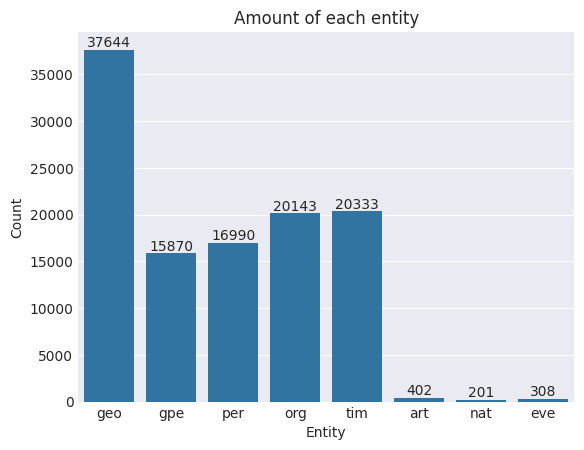

In [16]:
entities_count = dict(zip(entities, [0]*len(entities)))

for tags in tags_list:
    for entity in entities:
        entities_count[entity] += tags.count(f"B-{entity}")

ax = sns.barplot(entities_count)
ax.bar_label(ax.containers[0], fontsize=10);
plt.xlabel("Entity")
plt.ylabel("Count")
plt.title("Amount of each entity")
plt.show()

В датасете представлено больше всего географических(**geo**) сущностей. Достаточно много также сущностей типов **gpe**, **per**, **org**, **tim**. И очень мало сущностей типов **art**, **nat**, **eve**.

Напишем функцию создания тренировочных и тестовых данных нужного формата для обучения сети.

In [17]:
def train_test_create(sentences, tags, save_dir, test_size=0.3):
    (train_sentences,
     test_sentences,
     train_tags,
     test_tags) = train_test_split(sentences, tags, test_size=test_size, random_state=42)

    train_res = ""
    for sentence, tags in zip(train_sentences, train_tags):
        for word, tag in zip(sentence.split(" "), tags):
            train_res += f"{word} {tag}\n"

        train_res += "\n"

    test_res = ""
    for sentence, tags in zip(test_sentences, test_tags):
        for word, tag in zip(sentence.split(" "), tags):
            test_res += f"{word} {tag}\n"

        test_res += "\n"

    with open(os.path.join(save_dir, "train.txt"), "w") as f:
        f.write(train_res[:-2])

    with open(os.path.join(save_dir, "test.txt"), "w") as f:
        f.write(test_res[:-2])

In [18]:
train_test_create(sentences, tags_list, "data")

## NN approach

Для обучения сети использовался код из репозитория: https://github.com/dayyass/pytorch-ner

При установке данной библиотеки через pip install в google colab возникала
проблема, которая скорее всего связана с версией питона, установленной в колабе. Поэтому тренировка происходила локально с помощью кода из **train.py** и  конфига **config.yaml**(см. репозиторий).

Используемая архитектура рекуррентного слоя - Bidirectional LSTM

Загрузим полученную модель после тренировки в формате onnx

In [19]:
import json

import torch
import onnxruntime
import numpy as np
from tqdm import tqdm

In [20]:
ort_session = onnxruntime.InferenceSession("models/model_1/model.onnx")

Создадим функцию для загрузки тестовых данных и загрузим данные

In [21]:
def load_test_data(data_dir, model_dir):
    with open(os.path.join(model_dir, "label2idx.json")) as f:
        label2idx = json.load(f)
        idx2label = dict([(label2idx[label], label) for label in label2idx])

    with open(os.path.join(model_dir, "token2idx.json")) as f:
        token2idx = json.load(f)

    test_tokens_seq = []
    test_labels_seq = []
    with open(os.path.join(data_dir, "test.txt")) as f:
        tokens = []
        labels = []
        for line in f.readlines():
            if line != "\n":
                token, label = line.strip().split(" ")
                token = token.lower()
                tokens.append(token)
                labels.append(label)
            else:
                if len(tokens) > 0:
                    test_tokens_seq.append(tokens)
                    test_labels_seq.append(labels)
                tokens = []
                labels = []

    return test_tokens_seq, test_labels_seq, idx2label, token2idx

In [22]:
test_sentences, true_labels, idx2label, token2idx = load_test_data(
                                                        data_dir="data",
                                                        model_dir="models/model_1"
                                                        )

Создадим функцию для инференса сети и запустим сеть на тестовых данных

In [23]:
def model_predict(model, sentences, token2idx, idx2label):
    pred_labels = []
    for i in tqdm(range(len(sentences))):
        sentence = [token2idx[token] if token in token2idx else 1 for token in sentences[i]]
        lengths = [len(sentence)]

        ort_inputs = {"tokens": np.array([sentence]), "lengths": np.array(lengths)}
        pred_raw_tags = model.run(None, ort_inputs)[0]

        sentence_tags = []
        for raw_tag in pred_raw_tags[0]:
            torch_raw_tag = torch.tensor(raw_tag)
            tag = idx2label[torch.argmax(torch.softmax(torch_raw_tag, dim=0)).item()]
            sentence_tags.append(tag)
        pred_labels.append(sentence_tags)

    return pred_labels

In [24]:
pred_labels = model_predict(ort_session, test_sentences, token2idx, idx2label)

100%|██████████| 14387/14387 [00:25<00:00, 570.17it/s]


Создадим функции для подсчета entity-level метрик. Будем считать precision, recall и f1-score.

In [25]:
# Количество true positive в одном предложении
def tp_from_one_sentence(y_pred, y_true, entity="all"):
    i = 0
    tp = 0
    start_with = f"B-{entity}" if entity != "all" else "B"
    while i < len(y_true):
        if y_true[i].startswith(start_with) and y_true[i] == y_pred[i]:
            entity = y_true[i].split("-")[-1]
            i1, i2 = i + 1, i + 1

            while i1 < len(y_true) and y_true[i1] == f"I-{entity}":
                i1 += 1

            while i2 < len(y_pred) and y_pred[i2] == f"I-{entity}":
                i2 += 1

            if i1 == i2:
                tp += 1

            i = max(i1, i2)
        else:
            i += 1

    return tp

# Количество сущностей в предложении
def number_of_entities(y, entity="all"):
    num_entites = 0
    start_with = f"B-{entity}" if entity != "all" else "B"
    for tag in y:
        if tag.startswith(start_with):
            num_entites += 1

    return num_entites

# Получаем метрики со всего датасета
def get_metrics(true_labels, pred_labels, entity="all"):
    tp = 0
    num_pred_entites = 0
    num_true_entites = 0
    for i in range(len(pred_labels)):
        tp += tp_from_one_sentence(pred_labels[i], true_labels[i], entity=entity)
        num_pred_entites += number_of_entities(pred_labels[i], entity=entity)
        num_true_entites += number_of_entities(true_labels[i], entity=entity)

    precision = tp/num_pred_entites if num_pred_entites > 0 else 0
    recall = tp/num_true_entites
    f1_score = 2*precision*recall/(precision+recall) if precision+recall else 0

    return precision, recall, f1_score

In [26]:
precision, recall, f1_score = get_metrics(true_labels, pred_labels)

print(f"Precision:{round(precision, 2)}")
print(f"Recall:{round(recall, 2)}")
print(f"F1-score:{round(f1_score, 2)}")

Precision:0.86
Recall:0.84
F1-score:0.85


Получаем хорошие результаты с precision, recall и f1-score ~0.85

Посчитаем метрики по каждому типу сущности

In [27]:
table = PrettyTable(["Entity", "Precision", "Recall", "F1-score"])
for entity in entities:
    precision, recall, f1_score = get_metrics(true_labels, pred_labels, entity=entity)
    table.add_row([entity, round(precision, 2), round(recall, 2), round(f1_score, 2)])

print(table)

+--------+-----------+--------+----------+
| Entity | Precision | Recall | F1-score |
+--------+-----------+--------+----------+
|  geo   |    0.89   |  0.88  |   0.88   |
|  gpe   |    0.95   |  0.94  |   0.94   |
|  per   |    0.82   |  0.78  |   0.8    |
|  org   |    0.72   |  0.69  |   0.7    |
|  tim   |    0.9    |  0.89  |   0.9    |
|  art   |    0.25   |  0.27  |   0.26   |
|  nat   |    0.6    |  0.46  |   0.52   |
|  eve   |    0.68   |  0.46  |   0.55   |
+--------+-----------+--------+----------+


Хорошие результаты по метрикам получились с типами gpe, geo, tim, чуть хуже результаты с per и org, низкие метрики показывают nat, eve и art(для этих сущностей как раз было очень мало данных).

Попробуем улучшить метрики, увеличим размерность embedding'ов (128 -> 256) и размерность hidden_state'а(256->512)

In [28]:
ort_session = onnxruntime.InferenceSession("models/model_2/model.onnx")
test_sentences, true_labels, idx2label, token2idx = load_test_data(
                                                        data_dir="data",
                                                        model_dir="models/model_2"
                                                        )
pred_labels = model_predict(ort_session, test_sentences, token2idx, idx2label)
precision, recall, f1_score = get_metrics(true_labels, pred_labels)

print(f"Precision:{round(precision, 2)}")
print(f"Recall:{round(recall, 2)}")
print(f"F1-score:{round(f1_score, 2)}")

100%|██████████| 14387/14387 [01:16<00:00, 187.34it/s]

Precision:0.87
Recall:0.85
F1-score:0.86


In [29]:
table = PrettyTable(["Entity", "Precision", "Recall", "F1-score"])
for entity in entities:
    precision, recall, f1_score = get_metrics(true_labels, pred_labels, entity=entity)
    table.add_row([entity, round(precision, 2), round(recall, 2), round(f1_score, 2)])

print(table)

+--------+-----------+--------+----------+
| Entity | Precision | Recall | F1-score |
+--------+-----------+--------+----------+
|  geo   |    0.9    |  0.89  |   0.89   |
|  gpe   |    0.96   |  0.95  |   0.95   |
|  per   |    0.82   |  0.79  |   0.81   |
|  org   |    0.74   |  0.73  |   0.74   |
|  tim   |    0.91   |  0.9   |   0.91   |
|  art   |    0.7    |  0.35  |   0.47   |
|  nat   |    0.69   |  0.49  |   0.57   |
|  eve   |    0.58   |  0.52  |   0.55   |
+--------+-----------+--------+----------+


Получилось чуть увеличить метрики.

## Rule-based approach

### Базовая предобученная модель spacy

In [ ]:
%pip show spacy

Name: spacy
Version: 3.7.5
Summary: Industrial-strength Natural Language Processing (NLP) in Python
Home-page: https://spacy.io
Author: Explosion
Author-email: contact@explosion.ai
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: catalogue, cymem, jinja2, langcodes, murmurhash, numpy, packaging, preshed, pydantic, requests, setuptools, spacy-legacy, spacy-loggers, srsly, thinc, tqdm, typer, wasabi, weasel
Required-by: en-core-web-sm, fastai


In [ ]:
import spacy

# Загружаем предустановленную модель spacy (английский язык)
nlp = spacy.load("en_core_web_sm")
sent = sentences[226]
# print("True tags: ", tags_list[205])
print("Sentence: ", sent)
example_doc = nlp(sent)
print("Sentece entities: ", example_doc.ents)
print("\nLabels and indices:")
for ent in example_doc.ents:
    print(ent.start, ent.label_)

Sentence:  One of the 2008 Olympic mascots is modeled on a panda called Jing Jing .
Sentece entities:  (One, 2008, Jing Jing)

Labels and indices:
0 CARDINAL
3 DATE
12 PERSON


In [ ]:
for i in range(5):
    # print("========")
    print("Sentence: ", sentences[i])
    print("True tags: ", tags_list[i])
    example_doc = nlp(sentences[i])
    print("Sentece entities: ", example_doc.ents)
    print("\nLabels and indices:")
    for ent in example_doc.ents:
        print(ent.start, ent.end, ent.text, ent.label_)
    print("========")

Sentence:  Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .
True tags:  ['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']
Sentece entities:  (Thousands, London, Iraq, British)

Labels and indices:
0 1 Thousands CARDINAL
6 7 London GPE
12 13 Iraq GPE
18 19 British NORP
Sentence:  Families of soldiers killed in the conflict joined the protesters who carried banners with such slogans as " Bush Number One Terrorist " and " Stop the Bombings . "
True tags:  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-per', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Sentece entities:  (Stop the Bombings,)

Labels and indices:
25 28 Stop the Bombings WORK_OF_ART
Sentence:  They marched from the Houses of Parliament to a rally in Hyde Park .
True tags:  ['O', 'O', 'O', 'O'

Обращая внимания на примеры, становится понятно что лейблы могут называться по-другому, придется провести некоторый постпроцессинг

In [ ]:
print("Available entity labels in the model:")
for label in nlp.get_pipe("ner").labels:
    print(label)

Available entity labels in the model:
CARDINAL
DATE
EVENT
FAC
GPE
LANGUAGE
LAW
LOC
MONEY
NORP
ORDINAL
ORG
PERCENT
PERSON
PRODUCT
QUANTITY
TIME
WORK_OF_ART


In [ ]:
entities

['geo', 'gpe', 'per', 'org', 'tim', 'art', 'nat', 'eve']

Составим некоторый маппинг лейблов в наше пространство лейблов:

In [ ]:
label_mapping = {
    "CARDINAL": "O",
    "DATE": "tim",
    "EVENT": "eve",
    "FAC": "art",
    "GPE": "gpe",
    "LANGUAGE": "O",
    "LAW": "O",
    "LOC": "geo",
    "MONEY": "O",
    "NORP": "gpe",
    "ORDINAL": "O",
    "ORG": "org",
    "PERCENT": "O",
    "PERSON": "per",
    "PRODUCT": "O",
    "QUANTITY": "O",
    "TIME": "tim",
    "WORK_OF_ART": "art"
}

Маппинг приблизительный, плюс тут не нашлось нормальной ассоциации для "nat" (natural phenomenon), под которым в датасете представлены как имя панды "Jing Jing", так и элемент H5N1. Обращая внимание на статистику распределения лейблов, на метрике это должно отразиться не сильно.

In [ ]:
def spacy_to_bio(doc, sentence_length):
    tags = ["O"] * sentence_length
    for ent in doc.ents:
        if label_mapping[ent.label_] != "O":
            tags[ent.start] = f"B-{label_mapping[ent.label_]}"
            for i in range(ent.start + 1, ent.end):
                tags[i] = f"I-{label_mapping[ent.label_]}"
    return tags

predicted_tags = []
for sentence in sentences:
    doc = nlp(sentence)
    predicted_tags.append(spacy_to_bio(doc, len(doc)))

In [ ]:
precision, recall, f1_score = get_metrics(tags_list, predicted_tags)

print(f"Precision:{round(precision, 2)}")
print(f"Recall:{round(recall, 2)}")
print(f"F1-score:{round(f1_score, 2)}")

Precision:0.32
Recall:0.34
F1-score:0.33


In [ ]:
table = PrettyTable(["Entity", "Precision", "Recall", "F1-score"])
for entity in entities:
    precision, recall, f1_score = get_metrics(tags_list, predicted_tags, entity=entity)
    table.add_row([entity, round(precision, 2), round(recall, 2), round(f1_score, 2)])

print(table)

+--------+-----------+--------+----------+
| Entity | Precision | Recall | F1-score |
+--------+-----------+--------+----------+
|  geo   |    0.52   |  0.03  |   0.07   |
|  gpe   |    0.24   |  0.84  |   0.37   |
|  per   |    0.32   |  0.32  |   0.32   |
|  org   |    0.38   |  0.32  |   0.35   |
|  tim   |    0.46   |  0.58  |   0.51   |
|  art   |    0.04   |  0.09  |   0.05   |
|  nat   |     0     |  0.0   |    0     |
|  eve   |    0.07   |  0.19  |   0.1    |
+--------+-----------+--------+----------+


Получаем довольно низкие метрики.

### Подход только на правилах

Выберем следующий подход для написания правил:
1. Добавим базовые правила для некоторых классов, им свойственные
2. Рассмотрим каждый класс в датасете и найдем наиболее часто встречающиеся в нем токены (ключевые слова)

Инициализируем пайплайн и исключим из него модель `ner`

In [ ]:
from spacy.matcher import Matcher
from spacy.language import Language

from spacy.tokens import Span
import re

nlp = spacy.load("en_core_web_sm")

# Убираем компонент ner из пайплайна
nlp.remove_pipe("ner")

# Проверка пайплайна
print("Pipeline:", nlp.pipe_names)

Pipeline: ['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer']


Итак, наши сущности: `['geo', 'gpe', 'per', 'org', 'tim', 'art', 'nat', 'eve']`

Собираем по ним частотную статистику

In [ ]:
def get_tokens_freq_per_entity(sentences, tags_list):
    """
    Устарел, заменен на поиск словосочетаний
    """
    token_freq = {entity: {} for entity in entities}
    for sentence, tags in zip(sentences, tags_list):
        sentence = sentence.split()
        for i in range(len(tags)):
            if tags[i] != "O":
                if sentence[i] not in token_freq[tags[i].split("-")[-1]]:
                    token_freq[tags[i].split("-")[-1]][sentence[i]] = 0
                else:
                    token_freq[tags[i].split("-")[-1]][sentence[i]] += 1

    # for entity, freqs in token_freq.items():
    # for entity in entities
    return token_freq

In [ ]:
token_freq = get_tokens_freq_per_entity(sentences, tags_list)

In [ ]:
def get_topk_entity_freqs(token_freq, entity, k = 25):
    """устарел"""
    topk_geo = sorted(list(token_freq[entity].items()), key=lambda x: x[1], reverse=True)[:k]
    topk_geo_labels = [label for label, _ in topk_geo]
    entity_freqs = {k: v for k, v in token_freq[entity].items() if k in topk_geo_labels}
    return entity_freqs

In [ ]:
from collections import Counter

def get_entity_tokens_freq(sentences, tags_list, entity):
    """Находит частотные статистики слов (словосочетаний) в рамках одного лейбла"""
    multi_tokens = []
    for sentence, tags in zip(sentences, tags_list):
        sentence = sentence.split()
        for i in range(len(tags)):
            if tags[i] != "O":
                if tags[i] == f"B-{entity}":
                    multi_tokens.append([sentence[i]])
                elif tags[i] == f"I-{entity}":
                    multi_tokens[-1].append(sentence[i])
    for i in range(len(multi_tokens)):
        multi_tokens[i] = " ".join(multi_tokens[i])

    return Counter(multi_tokens)

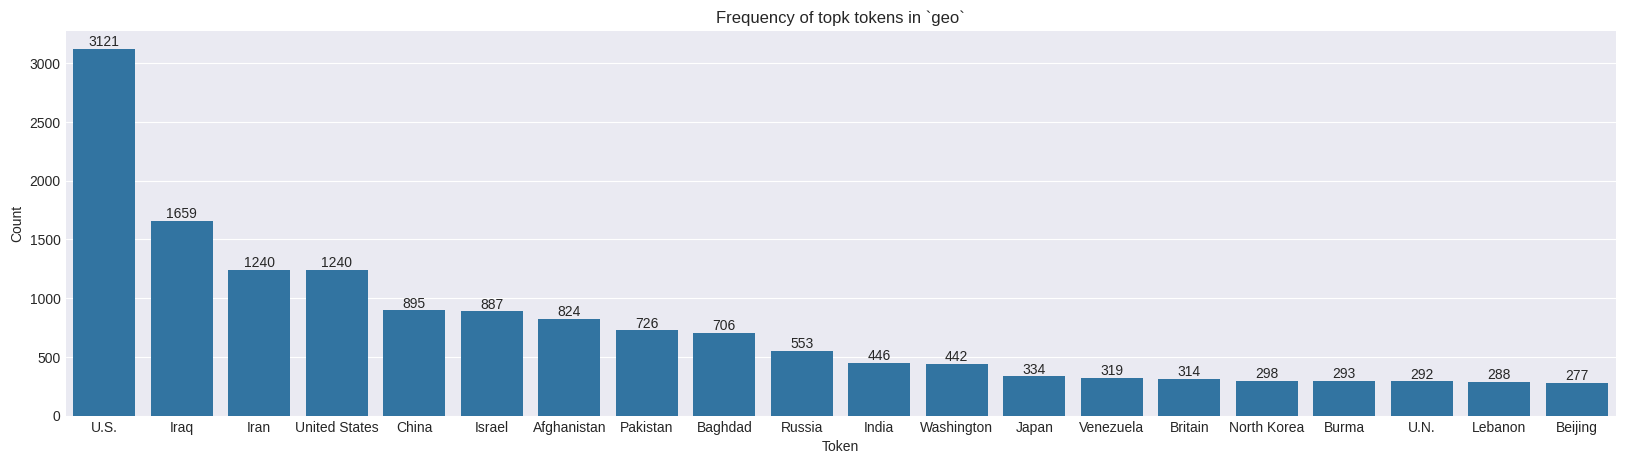

In [ ]:
geo_complex_counter = get_entity_tokens_freq(sentences, tags_list, "geo")
k = 30
geo_complex_keywords = {k: v for k, v in geo_complex_counter.most_common(k)}
fig, ax = plt.subplots(figsize=(20, 5))
ax = sns.barplot({k: v for k, v in geo_complex_counter.most_common(20)})
ax.bar_label(ax.containers[0], fontsize=10);
plt.xlabel("Token")
plt.ylabel("Count")
plt.title(f"Frequency of topk tokens in `geo`")
plt.show()

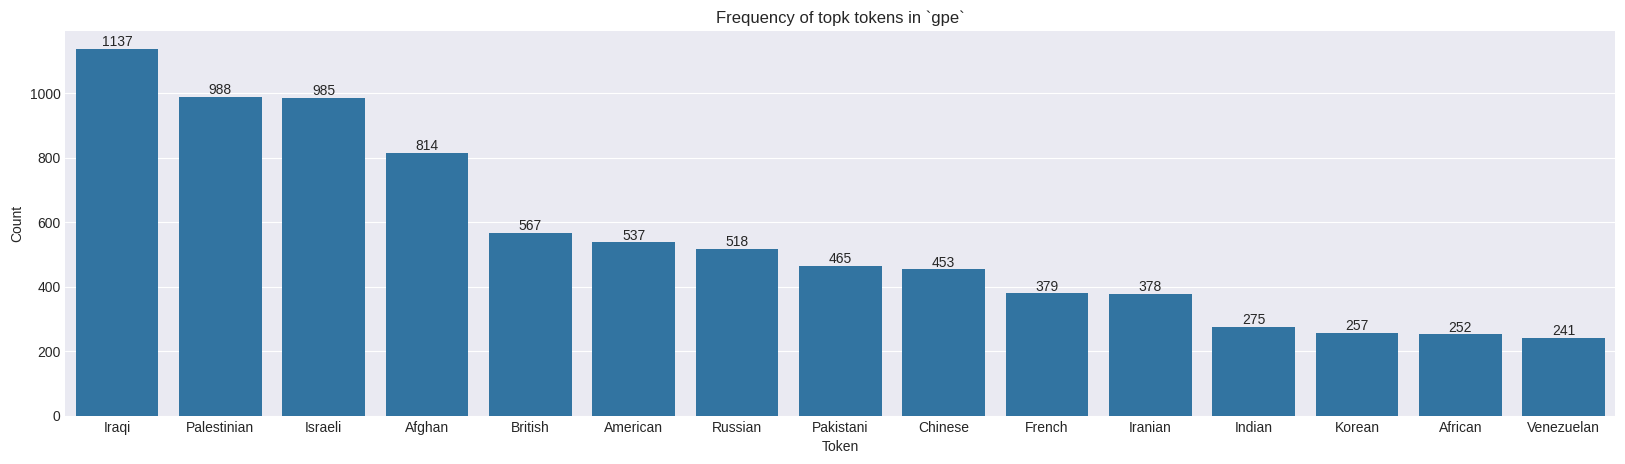

In [ ]:
gpe_complex_counter = get_entity_tokens_freq(sentences, tags_list, "gpe")
k = 30
gpe_complex_keywords = {k: v for k, v in gpe_complex_counter.most_common(k)}
fig, ax = plt.subplots(figsize=(20, 5))
ax = sns.barplot({k: v for k, v in gpe_complex_counter.most_common(15)})
ax.bar_label(ax.containers[0], fontsize=10);
plt.xlabel("Token")
plt.ylabel("Count")
plt.title(f"Frequency of topk tokens in `gpe`")
plt.show()

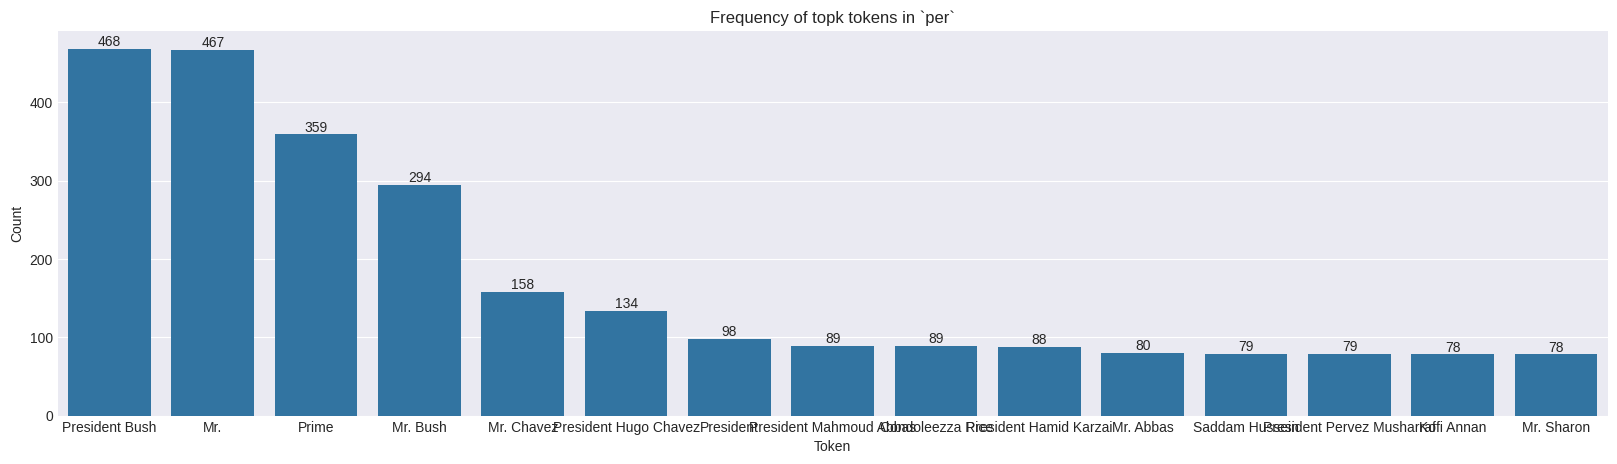

In [ ]:
per_complex_counter = get_entity_tokens_freq(sentences, tags_list, "per")
k = 50
per_complex_keywords = {k: v for k, v in per_complex_counter.most_common(k)}
fig, ax = plt.subplots(figsize=(20, 5))
ax = sns.barplot({k: v for k, v in per_complex_counter.most_common(15)})
ax.bar_label(ax.containers[0], fontsize=10);
plt.xlabel("Token")
plt.ylabel("Count")
plt.title(f"Frequency of topk tokens in `per`")
plt.show()

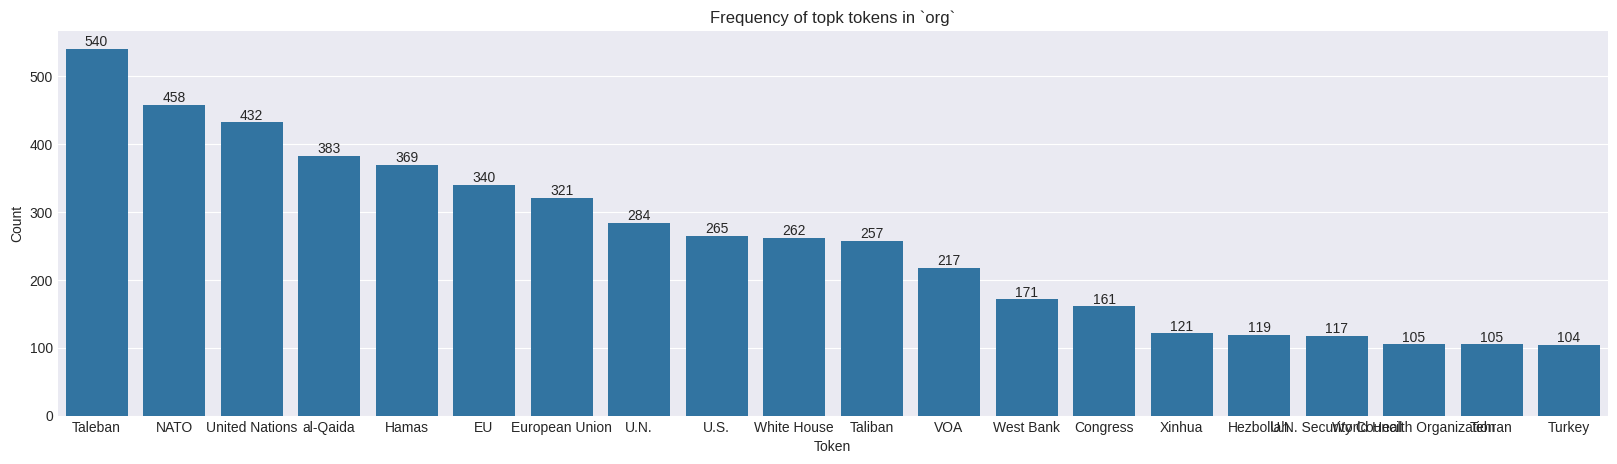

In [ ]:
org_complex_counter = get_entity_tokens_freq(sentences, tags_list, "org")
k = 50
org_complex_keywords = {k: v for k, v in org_complex_counter.most_common(k)}
fig, ax = plt.subplots(figsize=(20, 5))
ax = sns.barplot({k: v for k, v in org_complex_counter.most_common(20)})
ax.bar_label(ax.containers[0], fontsize=10);
plt.xlabel("Token")
plt.ylabel("Count")
plt.title(f"Frequency of topk tokens in `org`")
plt.show()

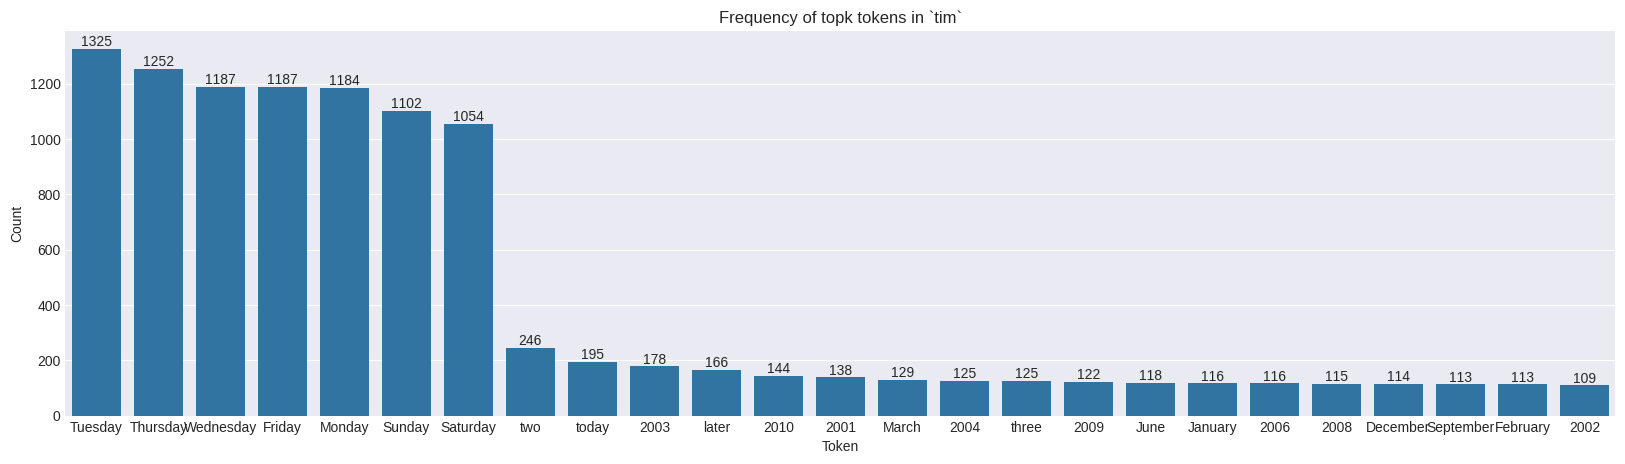

In [ ]:
tim_complex_counter = get_entity_tokens_freq(sentences, tags_list, "tim")
k = 25
tim_complex_keywords = {k: v for k, v in tim_complex_counter.most_common(k)}
fig, ax = plt.subplots(figsize=(20, 5))
ax = sns.barplot({k: v for k, v in tim_complex_counter.most_common(25)})
ax.bar_label(ax.containers[0], fontsize=10);
plt.xlabel("Token")
plt.ylabel("Count")
plt.title(f"Frequency of topk tokens in `tim`")
plt.show()

Таким методом мы цепляем предлоги от словосочетаний, и одновременно имеем очевидные сущности ограниченного количества, поэтому принято решение руками прописать встречаемые в данных сущности: дни недели, месяцы и даты.

In [ ]:
# tim_keywords = set(["Monday", "Tuesday", "Wendnesday", "Thursday", "Friday", "Saturday", "Sunday",
#                    "January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December",
#                     "one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "zero"
#                    ])
# + add regexp for `200?`

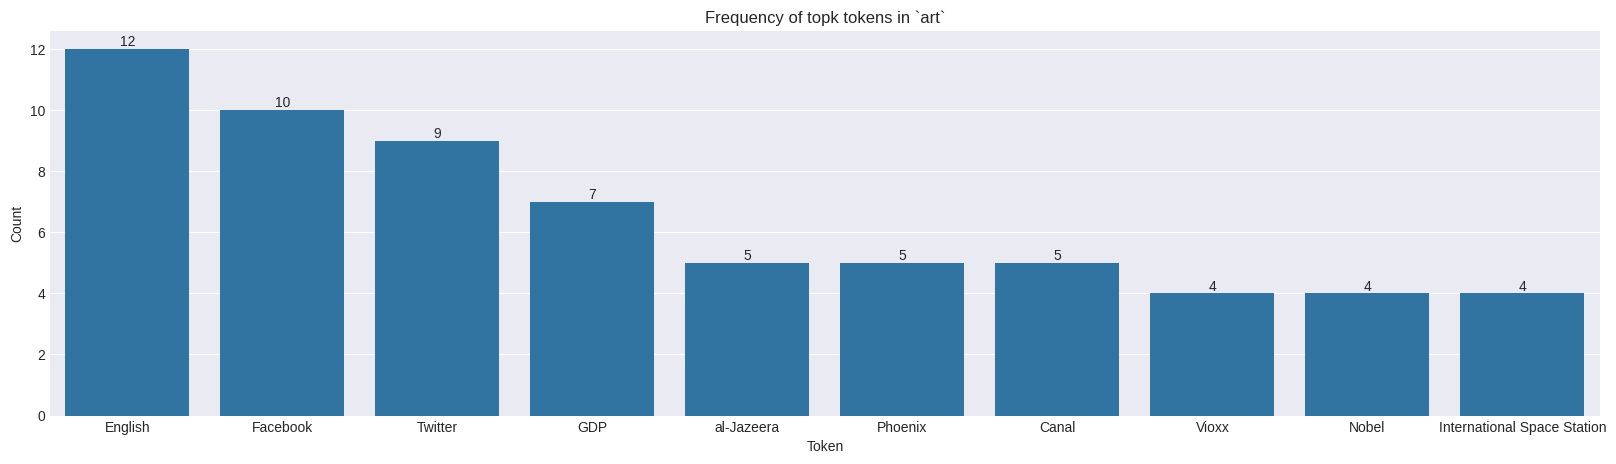

In [ ]:
art_complex_counter = get_entity_tokens_freq(sentences, tags_list, "art")
k = 10
art_complex_keywords = {k: v for k, v in art_complex_counter.most_common(k)}
fig, ax = plt.subplots(figsize=(20, 5))
ax = sns.barplot({k: v for k, v in art_complex_counter.most_common(10)})
ax.bar_label(ax.containers[0], fontsize=10);
plt.xlabel("Token")
plt.ylabel("Count")
plt.title(f"Frequency of topk tokens in `art`")
plt.show()

Учитывая несвязность слов, такие маленькие верхние бины и общее число объектов в 400+, такой подход хоть и будет неэфективен, но это не отразится на усредненной метрике

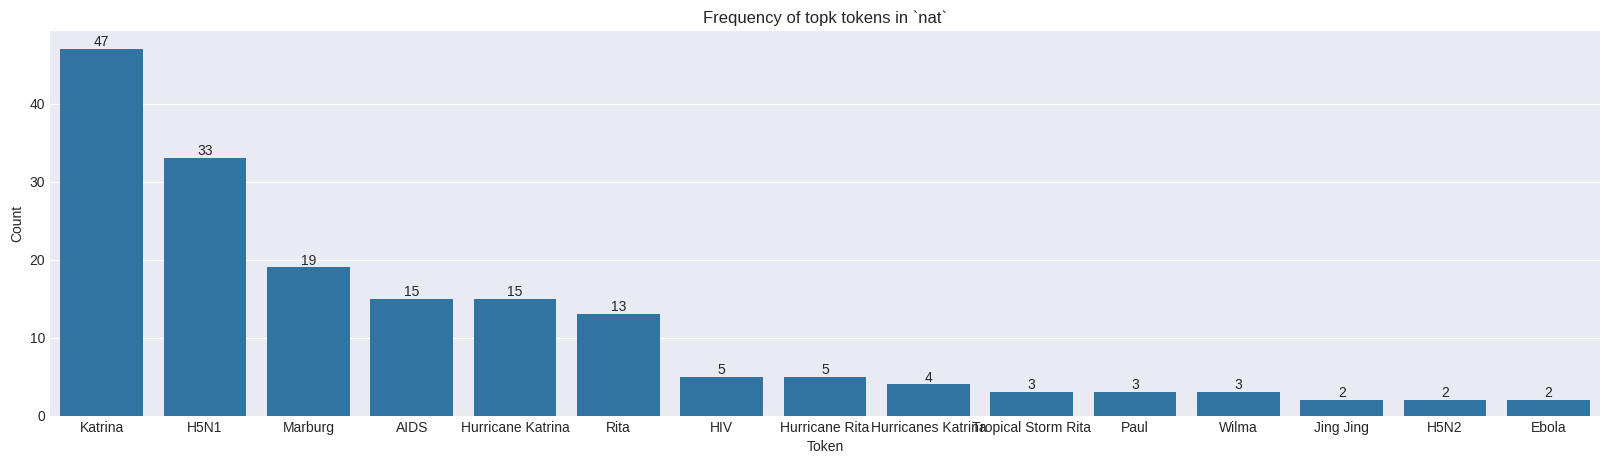

In [ ]:
nat_complex_counter = get_entity_tokens_freq(sentences, tags_list, "nat")
k = 15
nat_complex_keywords = {k: v for k, v in nat_complex_counter.most_common(k)}
fig, ax = plt.subplots(figsize=(20, 5))
ax = sns.barplot({k: v for k, v in nat_complex_counter.most_common(15)})
ax.bar_label(ax.containers[0], fontsize=10);
plt.xlabel("Token")
plt.ylabel("Count")
plt.title(f"Frequency of topk tokens in `nat`")
plt.show()

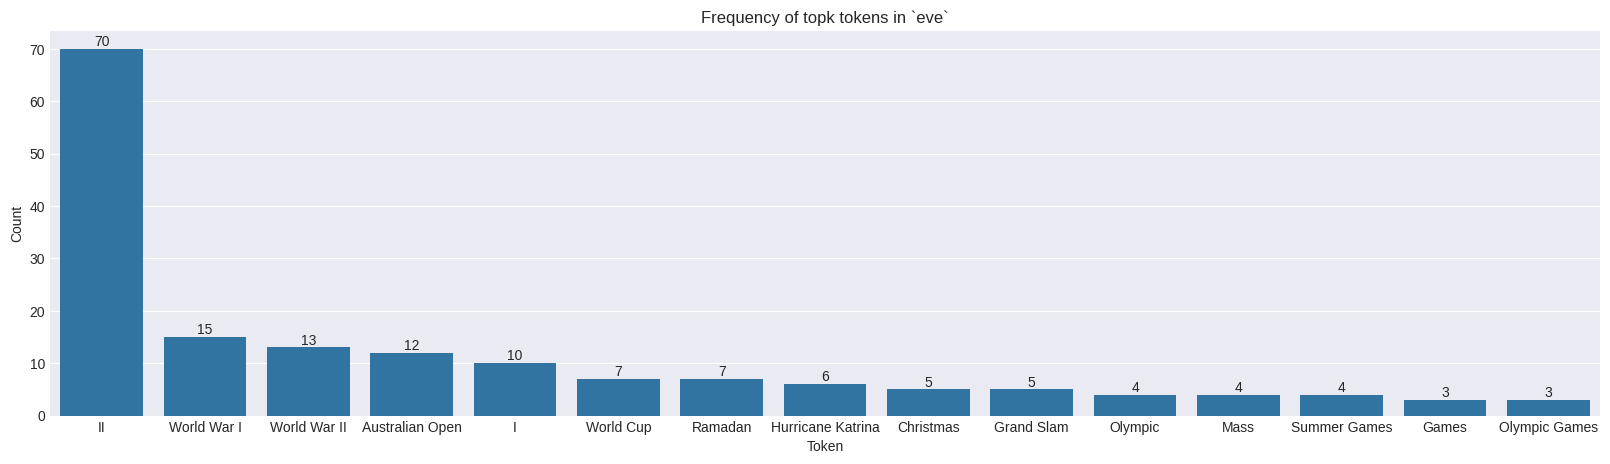

In [ ]:
eve_complex_counter = get_entity_tokens_freq(sentences, tags_list, "eve")
k = 15
eve_complex_keywords = {k: v for k, v in eve_complex_counter.most_common(k)}
fig, ax = plt.subplots(figsize=(20, 5))
ax = sns.barplot({k: v for k, v in eve_complex_counter.most_common(15)})
ax.bar_label(ax.containers[0], fontsize=10);
plt.xlabel("Token")
plt.ylabel("Count")
plt.title(f"Frequency of topk tokens in `eve`")
plt.show()

Учитывая малочисленность класса и составные сущности, просто добавим парочку самостоятельно:

In [ ]:
eve_keywords = set(["World War II", "World War I", "Christmas", "Olympics Games", "Australian Open", "Hurricane", "Ramadan"])

Начнем составлять пайплайн

In [ ]:
from spacy.matcher import PhraseMatcher

nlp = spacy.load("en_core_web_sm")

# Убираем компонент ner из пайплайна
nlp.remove_pipe("ner")

# Проверка пайплайна
print("Pipeline:", nlp.pipe_names)

phrase_matcher = PhraseMatcher(nlp.vocab)

Pipeline: ['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer']


In [ ]:
geo_matcher = PhraseMatcher(nlp.vocab, attr="LOWER")
gpe_matcher = PhraseMatcher(nlp.vocab, attr="LOWER")
per_matcher = PhraseMatcher(nlp.vocab, attr="LOWER")
org_matcher = PhraseMatcher(nlp.vocab, attr="LOWER")
tim_matcher = PhraseMatcher(nlp.vocab, attr="LOWER")
nat_matcher = PhraseMatcher(nlp.vocab, attr="LOWER")
art_matcher = PhraseMatcher(nlp.vocab, attr="LOWER")
eve_matcher = PhraseMatcher(nlp.vocab, attr="LOWER")

geo_keywords = set(geo_complex_keywords.keys())
gpe_keywords = set(gpe_complex_keywords.keys())
per_keywords = set(per_complex_keywords.keys())
org_keywords = set(org_complex_keywords.keys())
tim_keywords = set(tim_complex_keywords.keys())
nat_keywords = set(nat_complex_keywords.keys())
art_keywords = set(art_complex_keywords.keys())
eve_keywords = set(eve_complex_keywords.keys())

geo_patterns = [nlp.make_doc(text) for text in geo_keywords]
geo_matcher.add("geo", geo_patterns)

gpe_patterns = [nlp.make_doc(text) for text in gpe_keywords]
gpe_matcher.add("gpe", gpe_patterns)

per_patterns = [nlp.make_doc(text) for text in per_keywords]
per_matcher.add("per", per_patterns)

org_patterns = [nlp.make_doc(text) for text in org_keywords]
org_matcher.add("org", org_patterns)

tim_patterns = [nlp.make_doc(text) for text in tim_keywords]
tim_matcher.add("tim", tim_patterns)

nat_patterns = [nlp.make_doc(text) for text in nat_keywords]
nat_matcher.add("nat", nat_patterns)

art_patterns = [nlp.make_doc(text) for text in art_keywords]
art_matcher.add("art", art_patterns)

eve_patterns = [nlp.make_doc(text) for text in eve_keywords]
eve_matcher.add("eve", eve_patterns)

@Language.component("geo_keyword_ner")
def geo_phrase_matcher_ner(doc):
    matches = geo_matcher(doc)
    spans = [Span(doc, start, end, label="geo") for match_id, start, end in matches]
    return spans

@Language.component("gpe_keyword_ner")
def gpe_phrase_matcher_ner(doc):
    matches = gpe_matcher(doc)
    spans = [Span(doc, start, end, label="gpe") for match_id, start, end in matches]
    return spans

@Language.component("per_keyword_ner")
def per_phrase_matcher_ner(doc):
    matches = per_matcher(doc)
    spans = [Span(doc, start, end, label="per") for match_id, start, end in matches]
    return spans

@Language.component("org_keyword_ner")
def org_phrase_matcher_ner(doc):
    matches = org_matcher(doc)
    spans = [Span(doc, start, end, label="org") for match_id, start, end in matches]
    return spans

@Language.component("tim_keyword_ner")
def tim_phrase_matcher_ner(doc):
    matches = tim_matcher(doc)
    spans = [Span(doc, start, end, label="tim") for match_id, start, end in matches]
    return spans

@Language.component("nat_keyword_ner")
def nat_phrase_matcher_ner(doc):
    matches = nat_matcher(doc)
    spans = [Span(doc, start, end, label="nat") for match_id, start, end in matches]
    return spans

@Language.component("art_keyword_ner")
def art_phrase_matcher_ner(doc):
    matches = art_matcher(doc)
    spans = [Span(doc, start, end, label="art") for match_id, start, end in matches]
    return spans

@Language.component("eve_keyword_ner")
def eve_phrase_matcher_ner(doc):
    matches = eve_matcher(doc)
    spans = [Span(doc, start, end, label="eve") for match_id, start, end in matches]
    return spans

@Language.component("resolve_entity_conflicts")
def resolve_entity_conflicts(doc):
    geo_spans = geo_phrase_matcher_ner(doc)
    gpe_spans = gpe_phrase_matcher_ner(doc)
    per_spans = per_phrase_matcher_ner(doc)
    org_spans = org_phrase_matcher_ner(doc)
    tim_spans = tim_phrase_matcher_ner(doc)
    nat_spans = nat_phrase_matcher_ner(doc)
    art_spans = art_phrase_matcher_ner(doc)
    eve_spans = eve_phrase_matcher_ner(doc)

    all_spans = geo_spans + gpe_spans + per_spans + org_spans + tim_spans + nat_spans + art_spans + eve_spans

    filtered_spans = spacy.util.filter_spans(all_spans)

    doc.ents = list(doc.ents) + filtered_spans
    return doc

nlp.add_pipe("resolve_entity_conflicts", last=True)
print("Pipeline:", nlp.pipe_names)

Pipeline: ['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'resolve_entity_conflicts']


Собираем по отдельному правилу на каждую метку, потом разрешаем конфликты между правилами и внутри правил, иначе все упадет с ошибкой

In [ ]:
doc = nlp("God bless U.S. until World War II.")
print("Entities:", [(ent.text, ent.label_) for ent in doc.ents])

Entities: [('U.S.', 'geo'), ('World War II', 'eve')]


Видим что все работает (токен `U.S.` встречается в двух правилах на `geo` и `org`, а в `eve` присутствует как `'World War II'`, так и просто `'II'`).

Тем не менее все работает как часы)

Теперь смотрим что получилось по метрикам:

In [ ]:
def spacy_to_bio(doc, sentence_length):
    tags = ["O"] * sentence_length
    for ent in doc.ents:
        if ent.label_ != "O":
            tags[ent.start] = f"B-{ent.label_}"
            for i in range(ent.start + 1, ent.end):
                tags[i] = f"I-{ent.label_}"
    return tags

predicted_tags = []
for sentence in sentences:
    doc = nlp(sentence)
    predicted_tags.append(spacy_to_bio(doc, len(doc)))

table = PrettyTable(["Entity", "Precision", "Recall", "F1-score"])
for entity in entities:
    precision, recall, f1_score = get_metrics(tags_list, predicted_tags, entity=entity)
    table.add_row([entity, round(precision, 2), round(recall, 2), round(f1_score, 2)])

print(table)

+--------+-----------+--------+----------+
| Entity | Precision | Recall | F1-score |
+--------+-----------+--------+----------+
|  geo   |    0.76   |  0.42  |   0.54   |
|  gpe   |    0.84   |  0.63  |   0.72   |
|  per   |    0.38   |  0.22  |   0.28   |
|  org   |    0.47   |  0.28  |   0.35   |
|  tim   |    0.56   |  0.49  |   0.52   |
|  art   |    0.13   |  0.14  |   0.14   |
|  nat   |    0.18   |  0.66  |   0.28   |
|  eve   |    0.08   |  0.25  |   0.13   |
+--------+-----------+--------+----------+


In [ ]:
precision, recall, f1_score = get_metrics(tags_list, predicted_tags)

print(f"Precision:{round(precision, 2)}")
print(f"Recall:{round(recall, 2)}")
print(f"F1-score:{round(f1_score, 2)}")

Precision:0.61
Recall:0.41
F1-score:0.49


Получаем метрики выше бейзлайна, но ниже результатов нейронной сети.

Также эти метрики можно немного поднять играясь с topk токенов на каждой метке (напр. для `per` явно k стоит маленькое, метрика низкая, потому что имен много)